## Описание и задачи исследования

# Цель исследования

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Описание данных

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

Файл `games.csv`:

Столбцы:

* `Name` — название игры;
* `Platform` — платформа;
* `Year_of_Release` — год выпуска;
* `Genre` — жанр игры;
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий);
* `EU_sales` — продажи в Европе (миллионы проданных копий);
* `JP_sales` — продажи в Японии (миллионы проданных копий);
* `Other_sales` — продажи в других странах (миллионы проданных копий);
* `Critic_Score` — оценка критиков (максимум 100);
* `User_Score` — оценка пользователей (максимум 10);
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

В наборе данных попадается аббревиатура **ESRB (Entertainment Software Rating Board)** — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Данные за 2016 год могут быть неполными.

# Источник данных

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

# Задачи исследования

* Провести исследовательский анализ данных;
* Составить портрет пользователя каждого региона;
* Проверить гипотезы.

# Открытие данных

Импортируем все необходимые нам библиотеки и настройки `Pandas` для отображения данных при выводе:

In [1]:
import warnings
import pandas as pd
import numpy as np
from decimal import Decimal
import scipy.stats as stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go



warnings.filterwarnings('ignore', category=RuntimeWarning)# игнорируем предупреждения RuntimeWarning
pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
#округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["axes.formatter.limits"] = (-99, 99) #disable scientific notation on axes
plt.rcParams["figure.figsize"] = (18, 10)

Прочитаем файлы из папки `/datasets`.

In [2]:
path = '/datasets/'
web_path = '****'
data = 'games.csv'

try:
    raw_df = pd.read_csv(path + data)
except:
    raw_df = pd.read_csv(web_path + data)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Выведем на экран 5 случайных строк каждой из таблиц:

In [4]:
raw_df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1592,Pokemon XD: Gale of Darkness,GC,"2,005.00",Role-Playing,0.71,0.19,0.31,0.03,64.00,8.3,E
14133,Hakuouki: Zuisouroku DS,DS,"2,011.00",Adventure,0.00,0.00,0.04,0.00,NaN,NaN,NaN
12395,Dissidia: Final Fantasy Universal Tuning,PSP,"2,009.00",Fighting,0.00,0.00,0.06,0.00,NaN,NaN,NaN
7010,Colony Wars: Vengeance,PS,"1,998.00",Simulation,0.13,0.09,0.00,0.02,NaN,NaN,NaN
2892,South Park,PS,"1,998.00",Shooter,0.39,0.27,0.00,0.05,NaN,NaN,NaN


Предварительно можно сказать, что в данных имеются пропуски и нулевые значения, с которыми следует разобраться, помимо этого, названия столбцов следуеет привести к «змеиному регистру», также есть проблемы с типами данных.

## Предобработка данных

Проведем стандартную предобработку, включающаю проверку явных дубликатов, нулевых и пропущенных значений, а также изменим тип данных и преобразуем категориальные переменные.

Проверим данные на наличие аномалий.

Приведем возможные причины, догадки и аргументы касательно заполнения или удаления значений.

In [5]:
df = raw_df.copy()

### Преобразование названий столбцов

In [6]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Обработка дубликатов

In [7]:
print(f"Количество явных дубликатов: {df.duplicated().sum()}. Доля: {df.duplicated().sum()/df.shape[0]:.3%}.")

Количество явных дубликатов: 0. Доля: 0.000%.


In [8]:
print(f"Количество дубликатов в name: {df[df['name'].duplicated()].shape[0]}. Доля: {df[df['name'].duplicated()].shape[0]/df.shape[0]:.3%}.")

Количество дубликатов в name: 5155. Доля: 30.841%.


In [9]:
print(f"Количество уникальных значений в name: {df['name'].nunique()}. Доля: {df['name'].nunique()/df.shape[0]:.3%}.")

Количество уникальных значений в name: 11559. Доля: 69.153%.


В названиях игр присутствуют повторяющиеся названия, не трудно предположить, что скорее всего это связано с тем, что одинакова игра может выйти на разных платформах.

In [10]:
df[df['name'].duplicated()].sort_values('name').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,"2,013.00",Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
9507,007: Quantum of Solace,DS,"2,008.00",Action,0.11,0.01,0.00,0.01,65.00,tbd,T
4475,007: Quantum of Solace,PS2,"2,008.00",Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
1785,007: Quantum of Solace,PS3,"2,008.00",Action,0.43,0.51,0.02,0.19,65.00,6.6,T
3120,007: Quantum of Solace,Wii,"2,008.00",Action,0.29,0.28,0.01,0.07,54.00,7.5,T
14658,007: Quantum of Solace,PC,"2,008.00",Action,0.01,0.01,0.00,0.00,70.00,6.3,T
2243,007: The World is not Enough,PS,"2,000.00",Action,0.51,0.35,0.00,0.06,61.00,6.7,T
15656,11eyes: CrossOver,PSP,"2,010.00",Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
10076,18 Wheeler: American Pro Trucker,GC,"2,002.00",Racing,0.09,0.02,0.00,0.00,52.00,6.8,E
12283,187: Ride or Die,XB,"2,005.00",Racing,0.05,0.01,0.00,0.00,51.00,6.9,M


Это никак не повляет на анализ данных, т.к. нас интересуют данные по отедельности, т.е. в разбивке по другим признакам, а не анализ конкретных игр.

На примере игры **007: Quantum of Solace** видно, что она выпускается на 5 платформах, исходя из такого соотношения понятно, что почти 30% неявных дубликатов могут быть допустимы для исследуемой сферы.

Нередко игры могут выпускать абсолютно на всех платформах, поэтому наличие неявных дубликатов нормально для рассматривамой сферы бизнеса и как-то исправлять это мы не будем, т.к. у нас нет цели найти самые успешной продаваемые игры в жанре или регионе по признаку "название".

Более подробно факторов, которые могли послужить появлению неявных дубликатов мы коснемся в следюущем шаге.

### Обработка пропущенных значений


Создадим таблицы с указанием доли пропусков по каждой колонке, чтобы сэкономить наше время и потом удалить пропуски, или оставить их без изменений, где доля составляет не более 1%.

In [11]:
pd.concat([df.isna().sum(), df.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
name,2,0.01%
platform,0,0.00%
year_of_release,269,1.61%
genre,2,0.01%
na_sales,0,0.00%
eu_sales,0,0.00%
jp_sales,0,0.00%
other_sales,0,0.00%
critic_score,8578,51.32%
user_score,6701,40.09%


Больше всего пропусков присутсвует в столбцах, связанных с оценками и возрастным рейтингом игр: `critic_score` , `user_score`, `rating`, они не заполнены практически наполовину.

Однако, релевантные данные для заполнения пропусков отсутствуют, поэтому пока что мы оставим их как есть и изучим уникальные сзначения в этих столбцах.

Изучим данные столбца `year_of_release`, в котором содержится информация о годе релиза. Чтобы проверить одну из причин пропусков, отсортируем первые 15 строк по названи.

In [12]:
df[df['year_of_release'].isna()].sort_values('name').tail(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16180,WRC: FIA World Rally Championship,PC,NaN,Racing,0.00,0.01,0.00,0.00,65.00,NaN,RP
2773,WarioWare: Twisted!,GBA,NaN,Puzzle,0.16,0.06,0.50,0.02,NaN,NaN,NaN
3997,Wet,X360,NaN,Shooter,0.23,0.21,0.01,0.05,69.00,7.3,M
2157,Wheel of Fortune,PS2,NaN,Misc,0.47,0.36,0.00,0.12,NaN,tbd,E
15081,Wii de Asobu: Metroid Prime,Wii,NaN,Shooter,0.00,0.00,0.02,0.00,NaN,NaN,NaN
15816,Without Warning,XB,NaN,Shooter,0.01,0.00,0.00,0.00,45.00,2,M
14685,World of Tanks,X360,NaN,Shooter,0.00,0.03,0.00,0.00,NaN,5.2,NaN
15704,Writing and Speaking Beautiful Japanese DS,DS,NaN,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
2169,Yakuza 4,PS3,NaN,Action,0.15,0.13,0.63,0.05,78.00,8,M
11957,Yoostar on MTV,X360,NaN,Misc,0.07,0.00,0.00,0.01,49.00,tbd,T


In [13]:
print(df['year_of_release'].min())
df['year_of_release'].max()

1980.0


2016.0

Теоретически данные можно восстановить, но это очень трудозатратно по времени, если учесть тот факт, что в датасете представлены игры, которые выходили с 1980 по 2016 годы. О факторах, которые препятствуют восстановлению я скажу немного позже.

In [14]:
df.query('name == "World of Tanks"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6077,World of Tanks,PC,"2,011.00",Shooter,0.00,0.23,0.00,0.05,80.00,3.7,T
14685,World of Tanks,X360,NaN,Shooter,0.00,0.03,0.00,0.00,NaN,5.2,NaN


*Игра вышла 12 августа 2010 года и изначально имела только русскоязычную версию. Выпуск локализованной игры World of Tanks в Европе и в Северной Америке состоялся 12 апреля 2011 года.*

*На Xbox была выпущена 28 июля 2015 года. Она поддерживает кроссплатформенную игру между Xbox 360 и Xbox One.*

In [15]:
df.query('name == "Call of Duty: Black Ops"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
32,Call of Duty: Black Ops,X360,"2,010.00",Shooter,9.70,3.68,0.11,1.13,87.00,6.3,M
41,Call of Duty: Black Ops,PS3,"2,010.00",Shooter,5.99,4.37,0.48,1.79,88.00,6.4,M
1131,Call of Duty: Black Ops,PC,NaN,Shooter,0.58,0.81,0.00,0.23,81.00,5.2,M
1412,Call of Duty: Black Ops,Wii,"2,010.00",Shooter,0.80,0.45,0.00,0.12,80.00,5.8,M
3439,Call of Duty: Black Ops,DS,"2,010.00",Shooter,0.50,0.04,0.00,0.04,74.00,6,T


Мы можем попробовать найти информацию о бюджете из открытых источников, но при поиске придется писать уточняющие запросы по следующим причинам:
* Не все игры выходят одновременно во всех регионах, в основном это касается старых игр, т.к. раньше локализация замала очень много времени, как в случае с **World of Tanks**;
* Иногда в качестве релиза будет указана дата открытого или закрытого альфа-, либо бета-тестирования;
* Не все игры являются успешными франшизами как **Call of Duty** от **Activision**, которые с развитием консольного гейминга стали выпускать части данной франшизы ондовременно на всех платформах;
* Некоторые платформы имеют свои эксклюзивы, иногда бывает так, что игры спустя какое-то время портируются на PC, либо наоборот на консоль, и так возможно по кругу межджу каждой консолью. В таких случаях обычно пишут дату для каждого релиза, порой портировка из-за ряда бизнес-факторов случается через 5-10 лет.

In [16]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Можно было бы поменять тип на челочисленное число `int`, но в целом все в порядке.

In [17]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

`tbd` расшифровывается как **to be determinated**, что переводится как *будет определено* или *поделжит определению*, что можно понять как то, что оценки скорее всего еще на стадии опредления. Заменим его на заглушку `-10`, т.к. максмальная оценка `10`.

In [18]:
df['user_score'] = df['user_score'].replace('tbd', -10)

Для пропущенных значений рейтинга в `critic_score` и `user_score` в качестве заглушки будет `-1`.

In [19]:
df.fillna(df[['critic_score', 'user_score']].fillna(-1), inplace=True)

In [20]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Столбец с возрастным рейтингом также имеет пропуски. Теоретически их мохжно было бы заменить на `RP` **(Rating Pending)** - *Рейтинг ожидается*, но тогда данные могут сильно исказиться при дальнейшем исследовании, поэтому добавим аналогичную заглушку `unknown` - *неизвестно*.

Рейтинг от **ESRB** является рейтинговой для северо-американского региона, поэтому понятно почему могут присутсвовать пропуски или встречаться `RP`.

Для других регинов существуют свои рейтинговые системы оценок:

**PEGI** — европейская рейтинговая система компьютерных и видеоигр;

**CERO** — японская рейтинговая организация.

In [21]:
df['rating'].fillna('unknown', inplace=True)

In [22]:
pd.concat([df.isna().sum(), df.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
name,2,0.01%
platform,0,0.00%
year_of_release,269,1.61%
genre,2,0.01%
na_sales,0,0.00%
eu_sales,0,0.00%
jp_sales,0,0.00%
other_sales,0,0.00%
critic_score,0,0.00%
user_score,0,0.00%


Резюмируя данный шаг можно выдвинуть следующие предположения о причинах пропусков:

`year_of_release` - причина связана с разными датами появления на платформах, поэтому информация о таких играх не всегда обновляется быстро;

`critic_score` и `user_score` - это связано с тем, что критики не всегда успевают поиграть во все игры, а пользователи могут поиграть лишь на одной платформе, поэтому при сборе информации о оценках по каждой платформе могут быть пропуски, т.к. каждая платформа имеет разную оценку, т.к. качество игры на разных платформах может разниться по ряду разных причин;

`rating` - учитывается возрастной рейтинг от ESRB, рейтинг которой предназначен только для Северной Америки.


Строки с пропусками из этих столбцов удалить мы не можем, т.к. некоторые из них могут содержать информацию о жанре и  продажах в регионе, рейтинге для каждой платформы, которые понадобятся нам при составлении различных потретов. Заменить на заглушки их пришлось, т.к. метод `astype` не работает со значениями `NaN` при преобразовании в некоторые типы данных.

### Обработка нулевых значений

Создадим таблицы с указанием доли нулевых значений по каждой колонке.

In [23]:
pd.concat([df.eq(0).sum(), df.eq(0).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
name,0,0.00%
platform,0,0.00%
year_of_release,0,0.00%
genre,0,0.00%
na_sales,4508,26.97%
eu_sales,5870,35.12%
jp_sales,10514,62.90%
other_sales,6601,39.49%
critic_score,0,0.00%
user_score,0,0.00%


Согласно ТЗ проблем с нулевыми значениями не должно быть, да и для данного сегмента бизнеса такие цифры нормальны. Если судить по соотношению продаж, то доли выглядят правдоподобными, т.к. нельзя покрыть весь спрос и осуществлять продажи в каждом регионе из-за множества разных факторов.

### Преобразование типов данных

Приведем к правильному виду с помощью метода `astype()`:

* вещественный тип данных в столбце `year_of_release` год выпуска на целочисленный `int`;
* вещественный тип данных в столбце `critic_score` оценка критиков (максимум 100) на число с плавающей точкой `int`;
* строковый тип данных в столбце `user_score` оценка пользователей (максимум 10) на число с плавающей точкой `float64`;

In [24]:
df['user_score'] = df['user_score'].astype('float')

In [25]:
df['year_of_release'] = df['year_of_release'].astype("Int64")
df['user_score'] = df['user_score'].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  float64
 9   user_score       16715 non-null  float64
 10  rating           16715 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [26]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
4414,Super Bomberman 4,SNES,1996,Puzzle,0.00,0.00,0.44,0.00,-1.00,-1.00,unknown
16487,Command & Conquer Renegade,PC,2002,Shooter,0.00,0.01,0.00,0.00,-1.00,-1.00,unknown
5350,SoulCalibur,DC,1999,Fighting,0.00,0.00,0.34,0.00,98.00,8.80,T
13751,Call of Duty: Modern Warfare Trilogy,X360,2016,Shooter,0.02,0.02,0.00,0.00,-1.00,-10.00,M
1798,Sunset Overdrive,XOne,2014,Shooter,0.63,0.40,0.00,0.10,81.00,7.70,M
13948,E.T. The Extra-Terrestrial: Interplanetary Mis...,PS,2001,Platform,0.02,0.01,0.00,0.00,-1.00,-1.00,unknown
8131,Pro Evolution Soccer 2013,3DS,2012,Sports,0.05,0.02,0.10,0.01,-1.00,-1.00,unknown
15037,Cold War,XB,2005,Shooter,0.02,0.01,0.00,0.00,60.00,8.00,T
1853,Triple Play 98,PS,1997,Sports,0.61,0.42,0.00,0.07,-1.00,-1.00,unknown
13032,Koi to Senkyo to Chocolate Portable,PSP,2012,Adventure,0.00,0.00,0.05,0.00,-1.00,-1.00,unknown


### Анализ данных на наличие аномальных значений

Проведем корреляционный анализ, используя функцию `describe`.

In [27]:
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
year_of_release,"16,446.00","2,006.48",5.88,"1,980.00","2,003.00","2,007.00","2,010.00","2,016.00"
na_sales,"16,715.00",0.26,0.81,0.00,0.00,0.08,0.24,41.36
eu_sales,"16,715.00",0.15,0.50,0.00,0.00,0.02,0.11,28.96
jp_sales,"16,715.00",0.08,0.31,0.00,0.00,0.00,0.04,10.22
other_sales,"16,715.00",0.05,0.19,0.00,0.00,0.01,0.03,10.57
critic_score,"16,715.00",33.06,36.30,-1.00,-1.00,-1.00,70.00,98.00
user_score,"16,715.00",1.38,6.09,-10.00,-1.00,-1.00,7.30,9.70


Посмотрим на оценки, отфильтровав данные, не учитывая наши заглушки.

In [28]:
df[(df['critic_score']!=-1) & (df['user_score']>=0)].describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
year_of_release,"6,894.00","2,007.48",4.24,"1,985.00","2,004.00","2,007.00","2,011.00","2,016.00"
na_sales,"7,017.00",0.39,0.96,0.00,0.06,0.15,0.39,41.36
eu_sales,"7,017.00",0.23,0.68,0.00,0.02,0.06,0.21,28.96
jp_sales,"7,017.00",0.06,0.28,0.00,0.00,0.00,0.01,6.50
other_sales,"7,017.00",0.08,0.27,0.00,0.01,0.02,0.07,10.57
critic_score,"7,017.00",70.25,13.88,13.00,62.00,72.00,80.00,98.00
user_score,"7,017.00",7.18,1.44,0.50,6.50,7.50,8.20,9.60


Аномалий не наблюдается.

### Добавление новых столбцов

Создадим столбец `total_sales` с суммарными продажами во всех регионах.

In [29]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.00,-1.00,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.00,-1.00,unknown,31.38


### Вывод

Как выяснилось, номалии отсутсвуют.

Также названия столбцов были приведены к "змеиному регистру" и к `critic_score`, `user_score`, `rating` были применен соответсвующие типы данных.

Создали столбец `total_sales` с суммарными продажами во всех регионах.

Были выявлены нулевые значения в продажах по регионам, но такое дейсвительно может быть.

В данных есть неявные дубликаты в `name` названиях игр, но это нормально, т.к. присутсвует фактор мультиплатформенности.

**Были выявлены слеюущие причины пропусков:**

`year_of_release` - появления на платформах, поэтому информация о таких играх не всегда обновляется быстро;

`critic_score` и `user_score` - при сборе информации о оценках по каждой платформе могут быть пропуски, т.к. каждая платформа имеет разную оценку, следовательно, в какую-то из игр на платформе просто еще не успели поиграть после релиза или длч нее оставили достаточно оценок;

`rating` - учитывается возрастной рейтинг от ESRB, рейтинг которой предназначен только для Северной Америки.

Столбцы `year_of_release`, `critic_score` и `user_score`, `rating` можно было дополнить вручную выполнив поиск, но релевантные данные для заполнения пропусков отсутствуют, поэтому оставим их как есть, заменив проблемные значения строк на заглушки.

## Анализ данных

### Количество выпущенных игр по годам

Чтобы проанализировать данные о ежегодном выпуске игра, сгруппируем датафрейм по годам и посчитаем количество игр с помощью сводной таблицы.

In [30]:
released_by_year = df.pivot_table(index='year_of_release',
                                          values='name',
                                          aggfunc='count')

Теперь визуализируем ее в виде столбчатого графика.

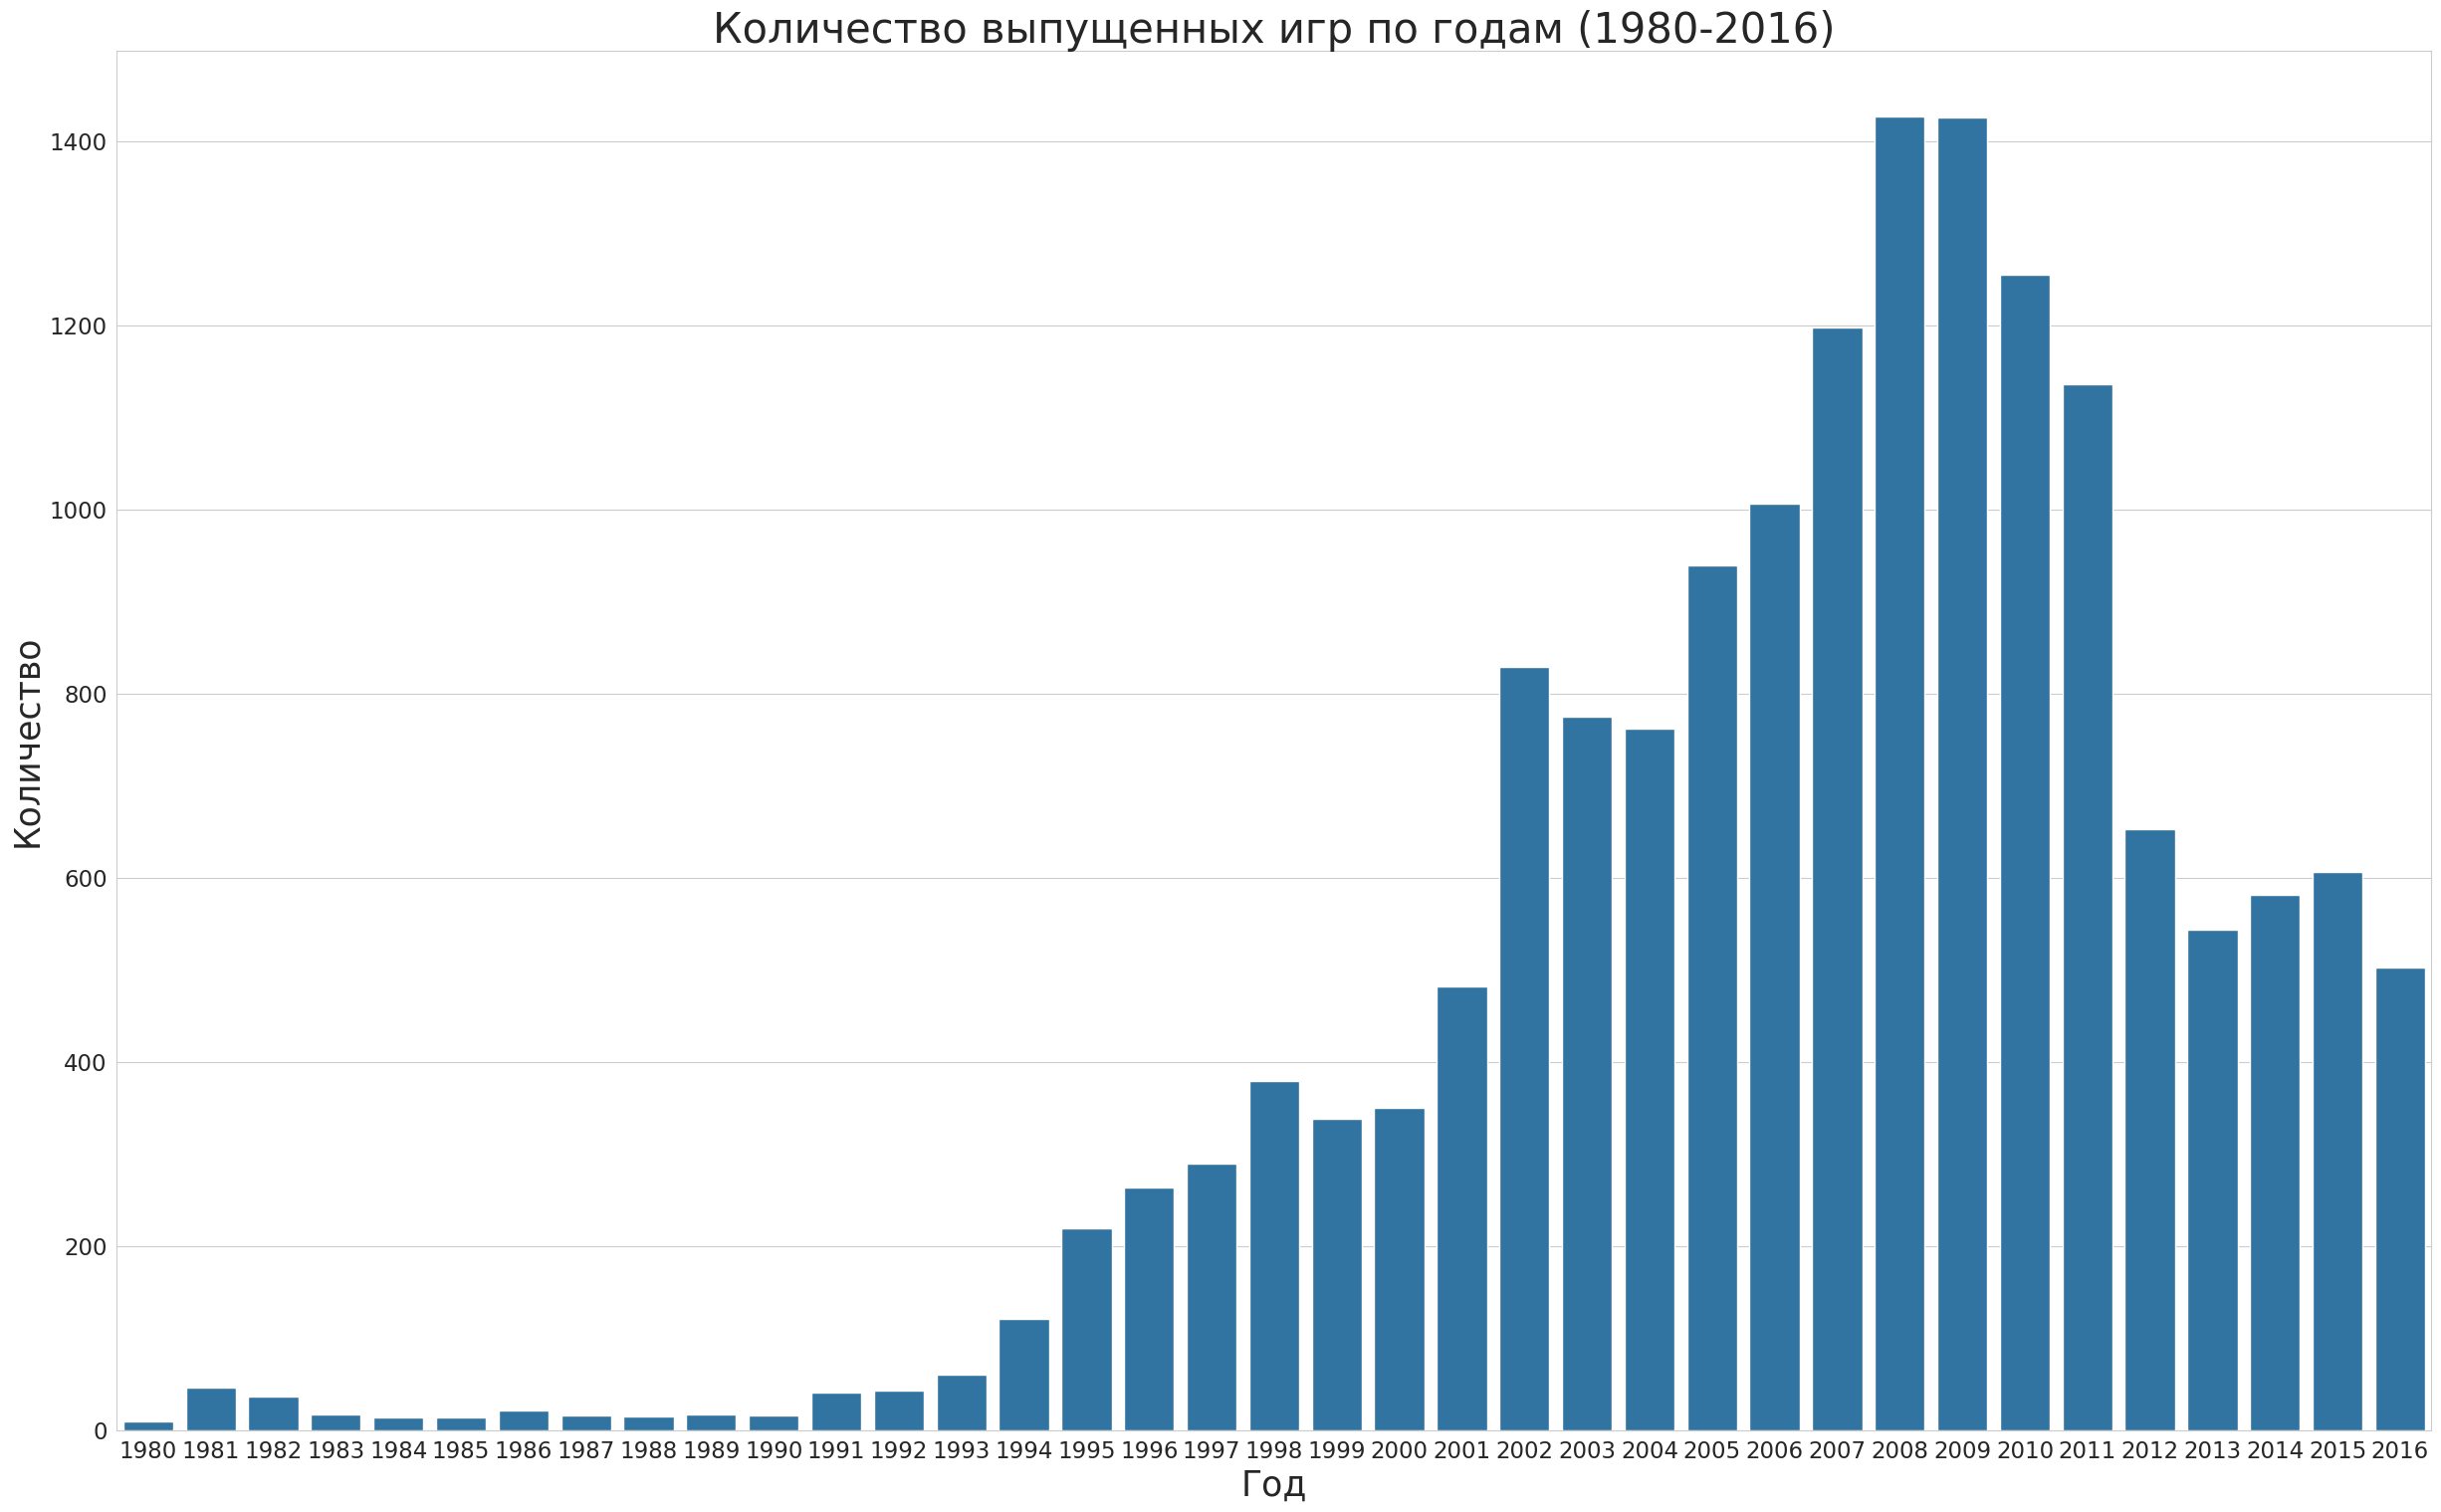

In [31]:
plt.figure(figsize=(30, 18))
sns.set_style('whitegrid')
sns.barplot(data=released_by_year, x=released_by_year.index, y='name')
plt.xlabel('Год', fontsize=25)
plt.ylabel('Количество', fontsize=25)
plt.title('Количество выпущенных игр по годам (1980-2016)', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=16.5)
plt.show()

Рост выпущенных игр начинается с 2001 года (около 500), а пик приходится на 2008-2009 годы (свыше 1400), однако, с наступлением 2010 года начинается спад вплоть до 2016 года, который имеет почти такое же количество как в 2001 году.

###  Продажи игр на популярных платформах

В качестве популярных платформ возьмем 15 лучших по продажам, для этого создадим сводную таблицу.

In [32]:
sales_by_platform = df.pivot_table(index='platform',
                                values='total_sales',
                                aggfunc='sum')\
    .sort_values(by='total_sales', ascending=False).head(15)

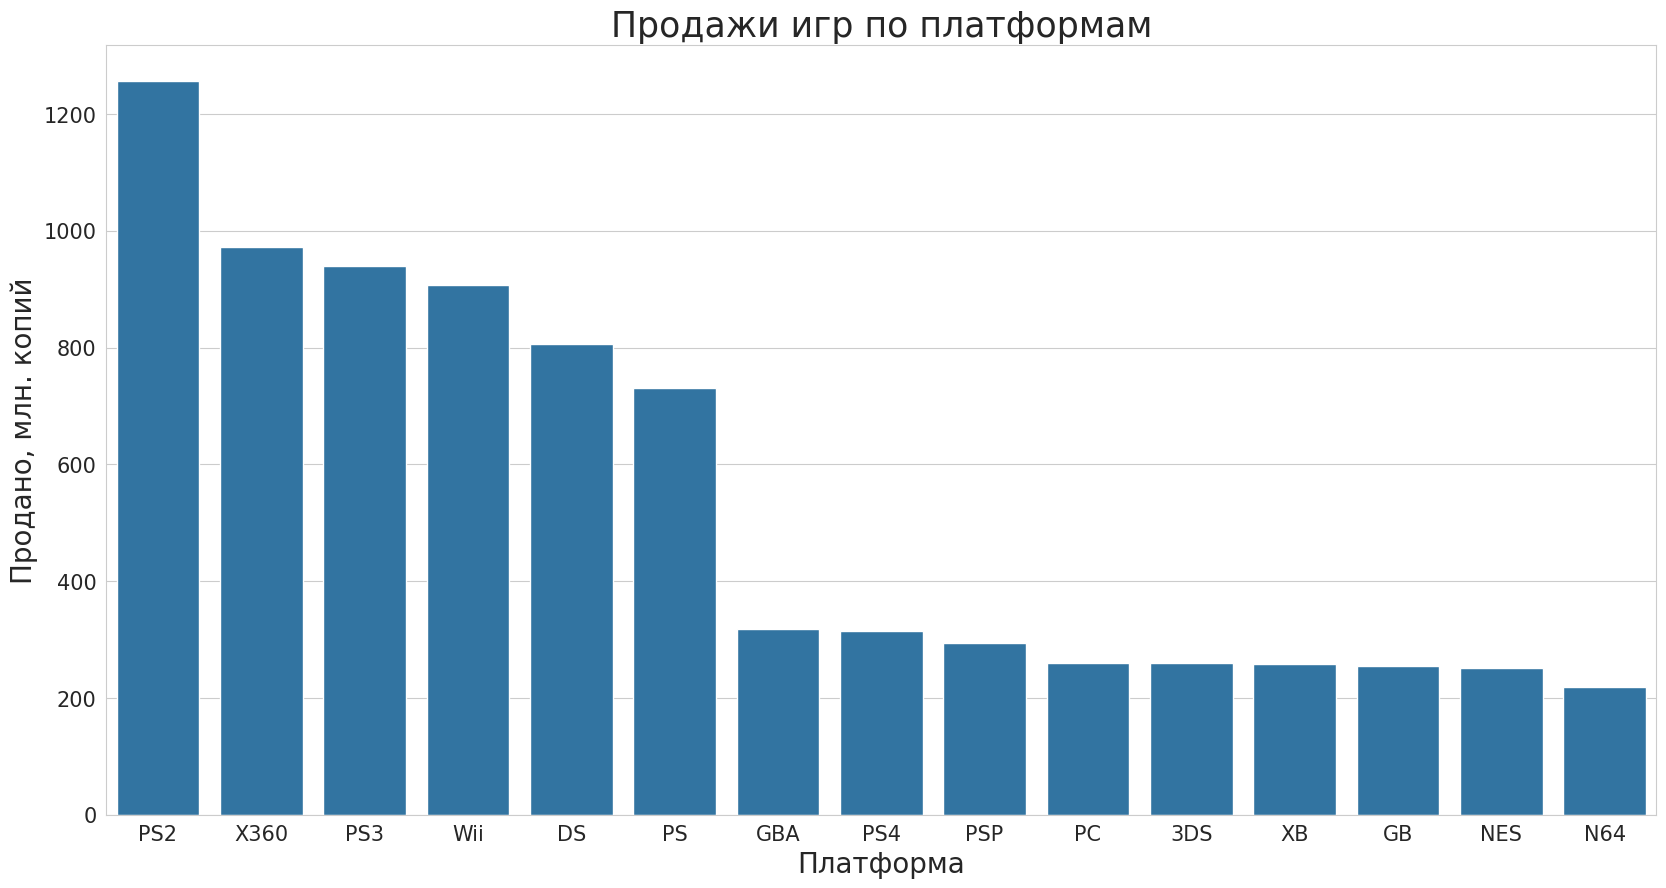

In [33]:
plt.figure(figsize=(20, 10))
sns.barplot(data=sales_by_platform, x=sales_by_platform.index, y='total_sales')
plt.xlabel('Платформа', fontsize=20)
plt.ylabel('Продано, млн. копий', fontsize=20)
plt.title('Продажи игр по платформам', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

В пятерку лидеров входят: PlayStation 2, Xbox 360, PlayStation 3, Nintendo Wii, Nintendo DS, также стоит отметить успех PlayStation, которая была выпущена в 1994 году и поддерживалась вплоть до 2006 года, однако ее продавали и после.

Лучше всего продаются игры на PS2 - более 1,2 млрд. копий, на втором месте Xbox 360 - почти 1 млрд. копий. Видно, что на рынке в рассматриваемые периоды доминирует такие корпорации как Sony и Nintendo. Но было ли так всегда, и как ситуация обстоит в последние годы?

Чтобы ответить на этот вопрос создадим список с топ-10 платформами по продажам и добавим его в сводную таблицу.

In [34]:
top_sales_by_platform = sales_by_platform.reset_index().head(10)['platform'].tolist() #список

top_sales_by_platform = df.query('platform in @ top_sales_by_platform').pivot_table(index=['year_of_release', 'platform'],
                                              values='total_sales',
                                              aggfunc='sum').\
                             sort_values(by='year_of_release', ascending=False).\
                             reset_index()

In [35]:
fig = px.line(data_frame=top_sales_by_platform,
              x='year_of_release',
              y='total_sales',
              color='platform',
              template='seaborn',
              labels={'total_sales':'Продано копий, млн. шт.',
                      'year_of_release':'Год',
                      'platform':'Платформа'})
fig.update_layout(title_text='Динамика продаж игр по платформам', title_x=0.5)
fig.show()

Но сколько составляет средний срок жизни платформы? Как долго они могут быть актуальны?

In [36]:
platform_lifetime = df.groupby('platform').agg({'year_of_release':['min','max']})
platform_lifetime.columns = ['year_min','year_max']
platform_lifetime['lifetime'] = platform_lifetime['year_max']-platform_lifetime['year_min']

platform_lifetime['lifetime'].median()

6.0

По графику продаж видно, что примерно каждые 5 лет появляется новая платформа. В целом платформа актуальна лет 5, а потом примерно в течение года после этого срока она перестает существовать. Однако, средний срок жизни платформы составляет 6 лет.

Да, наше предположение подтвердилось, до 2000 года лидеровала PS, но с выходом PS2 перехватила лидерство, а в 20007 ее сменила PS3.

Если тезисно по продажам в данном магазине, то:
* **До 1994 года**, из топ-10 платформ представленных сегодня, конкурировали только **Nintendo DS и PC**;
* **С 1994 по 2001 годы** практически единолично на рынке лидировала **PS**, пик продаж приходится на **1998 год - 169,49 млн. копий**;
* **С 2001 по 2007 годы** лидировала **PS2 - 211,81 млн. копий в 2004 году**, а на втором месте с большой разницей был GBA (Game Boy Advance) от Nintendo;
* **До 2010 года:** набирала популярность Nintendo DS (292 млн. копий за 2007-2008 годы) - портативная консоль, позиционирующая себя как карманная, но на первом месте была **Nintendo Wii (206,97 млн. копий в 2009 году)**, которая была чем-то вроде ноу-хау. Параллельно за топ-3 боролись PS3 и Xbox 360 (170 млн. копий в 2010 году), последний пользовался спросом за счет более низкой цены и гораздо дешевых игр;
* **C 2010 до 2013** все также доминировали наравне **PS3 (156,78 млн. копий в 2011 году)** и Xbox 360 (113 млн. в 2013 году, но пик все также приходится на 2010);
* **С конца 2013 года и до сегодняшнего дня** с большим отрывом стали лидировать продажи игр на **PS4 (почти 119 млн. в 2015 году)**. Это связано с провалом Xbox One и эксклюзивами в PS Store, также подобные провалы в этом периоды связаны с некоторым отсутсвующими годами релизов и неполнотой данных за 2016 год.

Примерно каждые 5 лет появляется новая платформа. В целом платформа актуальна лет 5, а потом примерно в течение года после этого срока она перестает существовать. Однако, средний срок жизни платформы составляет 6 лет.

### Актуальные продажи игр по платформам

В качестве актуального периода возьмем последние 5 лет, включая текущий, т.е. 2012 - 2016 года.

In [37]:
actual_df = df.query('year_of_release >= 2012')
latest_sales_by_platform = top_sales_by_platform.query('year_of_release >= 2012 and total_sales > 0')

Построим линейные графики с динамикой с 2012 по 2016 годы.

In [38]:
fig = px.line(data_frame=latest_sales_by_platform,
              x='year_of_release',
              y='total_sales',
              color='platform',
              template='seaborn',
              labels={'total_sales':'Продано копий, млн. шт.',
                      'year_of_release':'Год',
                      'platform':'Платформа'})
fig.update_layout(title_text='Динамика продаж игр по платформам c 2012 по 2016 годы', title_x=0.5)
fig.show()

Все тоже самое: PSP, DS полностью ушли с рынка, а PS3, Xbox 360 и Wii его медленно покидают, пока PS4 набирает обороты.

### Распределение глобальных продаж игр в разбивке по платформам

In [39]:
pivot_platform = df.pivot_table(index='platform', values='total_sales', aggfunc = ['count','median','sum'])
pivot_platform.columns = ['count', 'median','sum']
pivot_platform = pivot_platform.sort_values(by = 'sum', ascending = False)
pivot_platform.head()

,count,median,sum
platform,,,
PS2,2161,0.23,"1,255.77"
X360,1262,0.28,971.42
PS3,1331,0.27,939.65
Wii,1320,0.19,907.51
DS,2151,0.11,806.12


Чтобы лучше показать распределение и получить возможность фильтровать платформы визуализируем все с помощью библиотеки `plotly`

In [40]:
fig = px.box(df, y="total_sales", x="platform", color="platform")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Глобальные продажи игр в разбивке по платформам',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  yaxis_range=[df['total_sales'].min(), 18],
                  xaxis_title='Платформы',
                  yaxis_title='Продано копий, млн. шт.')
fig.update_xaxes(range=[-1, 9.5])
fig.show()

In [41]:
fig = px.box(df, y="total_sales", x="platform", color="platform")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Глобальные продажи игр в разбивке по платформам',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  yaxis_range=[df['total_sales'].min(),2],
                  xaxis_title='Платформы',
                  yaxis_title='Продано копий, млн. шт.')
fig.update_xaxes(range=[-1, 9.5])
fig.show()

Продажи на популярных платформах схожи. Однако, медианные значения продаж у четырех Wii, PS2, PS4, GBA находятся близко к уровню 0,2, а у Xbox 360, PS3, SNES к уровню в диапазоне 0,25-0,3, NES и GB находятся на уровне вышн 1.

На платформах Xbox 360, PS3, PS4 и SNES большая часть проданых игр лежит до значения в 0,5-0,6, на платформах Xbox 360, PS3, PS4 и SNES чуть выше 0,7, а в лидерах NES и GB - выше 2, но это можно связать с тем, что срок жизни данных платформ гораздо больше, поэтому лучше исследовать диграммы по актуальным данным.

Для наглядности также построим круговую диаграмму.

In [42]:
fig = px.pie(df, values=df['total_sales'], names=df['platform'], title='Распределение игр по платформам')
fig.update_layout(
    title_x = 0.45)
fig.show()

В пятерку лидеров входят: PlayStation 2, Xbox 360, PlayStation 3, Nintendo Wii, Nintendo DS, но учитывая продажи лучше присмотреться в сторону PS3 и Xbox 360.

### Распределение актуальных продаж игр в разбивке по платформам

In [43]:
pivot_platform_a = actual_df.pivot_table(index='platform', values='total_sales', aggfunc = ['count','median','sum'])
pivot_platform_a.columns = ['count', 'median','sum']
pivot_platform_a = pivot_platform.sort_values(by = 'sum', ascending = False)
pivot_platform_a

,count,median,sum
platform,,,
PS2,2161,0.23,"1,255.77"
X360,1262,0.28,971.42
PS3,1331,0.27,939.65
Wii,1320,0.19,907.51
DS,2151,0.11,806.12
PS,1197,0.26,730.86
GBA,822,0.16,317.85
PS4,392,0.20,314.14
PSP,1209,0.09,294.05


In [44]:
fig = px.box(actual_df, y="total_sales", x="platform", color="platform")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Глобальные продажи игр в разбивке по платформам c 2012 по 2016 годы',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  yaxis_range=[df['total_sales'].min(), 18],
                  xaxis_title='Платформы',
                  yaxis_title='Продано копий, млн. шт.')
fig.show()

In [45]:
fig = px.box(actual_df, x="total_sales", y="platform", color="platform")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Глобальные продажи игр в разбивке по платформам c 2012 по 2016 годы',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-0.0009, 1],
                  yaxis_title='Платформы',
                  xaxis_title='Продано копий, млн. шт.')
fig.show()

На актуальных медианные значения продаж у PS3, PS4, Xbox One, Wii, WiiU  находятся близко к уровню 0,2, лучше всего себя показывает Xbox 360 - 0,31. Лучше всего значения по по продажам имеет Xbox 360, т.к. большая часть проданных игр находится на уровне выше 0,8 (0,87), но PS4 на фоне остальных выглядит лучше всех - 0,73, среди неплохих платформ также стоит выделить PS3, Wii и Xbox One, которые находятся на уровне 0,5-0,6.

Для наглядности также построим круговую диаграмму.

In [46]:
fig = px.pie(actual_df, values=actual_df['total_sales'], names=actual_df['platform'],
             title='Распределение игр по платформам c 2012 по 2016 годы')
fig.update_layout(
    title_x = 0.5)
fig.show()

**Вывод:**

- В качестве перспективной платформы (на ближайшие 5 лет), которая будет приносить доход стоит выделить PlayStation 4 и Xbox One.

- Если говорить о краткосрочном периоде, то PlayStation 3 и Xbox 360 - достаточно высокое медианное значение продаж и большой перекос в положительную сторону.

### Влияние отзывов пользователей и критиков на продажи.

Мы решили не ограничиваться одной платформой и взяи топ-5 платформ, для которой мы построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

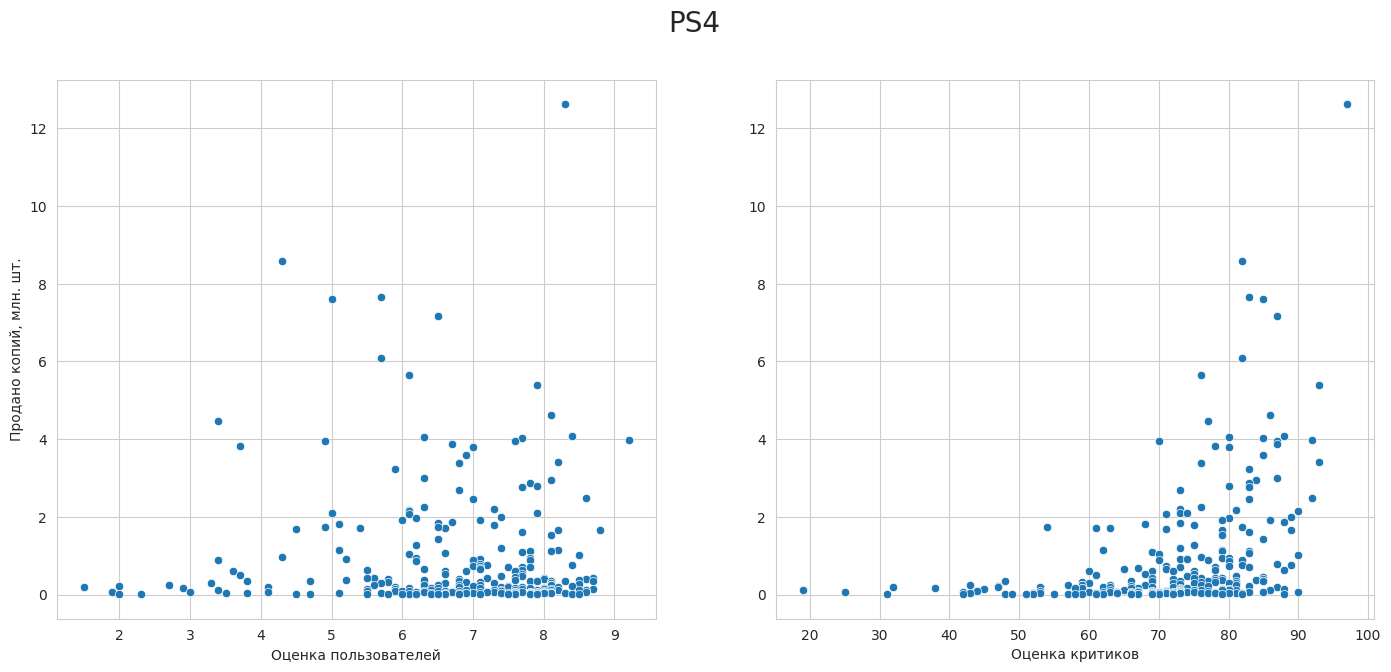

Коэффициент линейной корреляции между продажами игр на платформе PS4 и оценкой пользователей: -0.032.

Коэффициент линейной корреляции между продажами игр на платформе PS4 и оценкой критиков: 0.407.


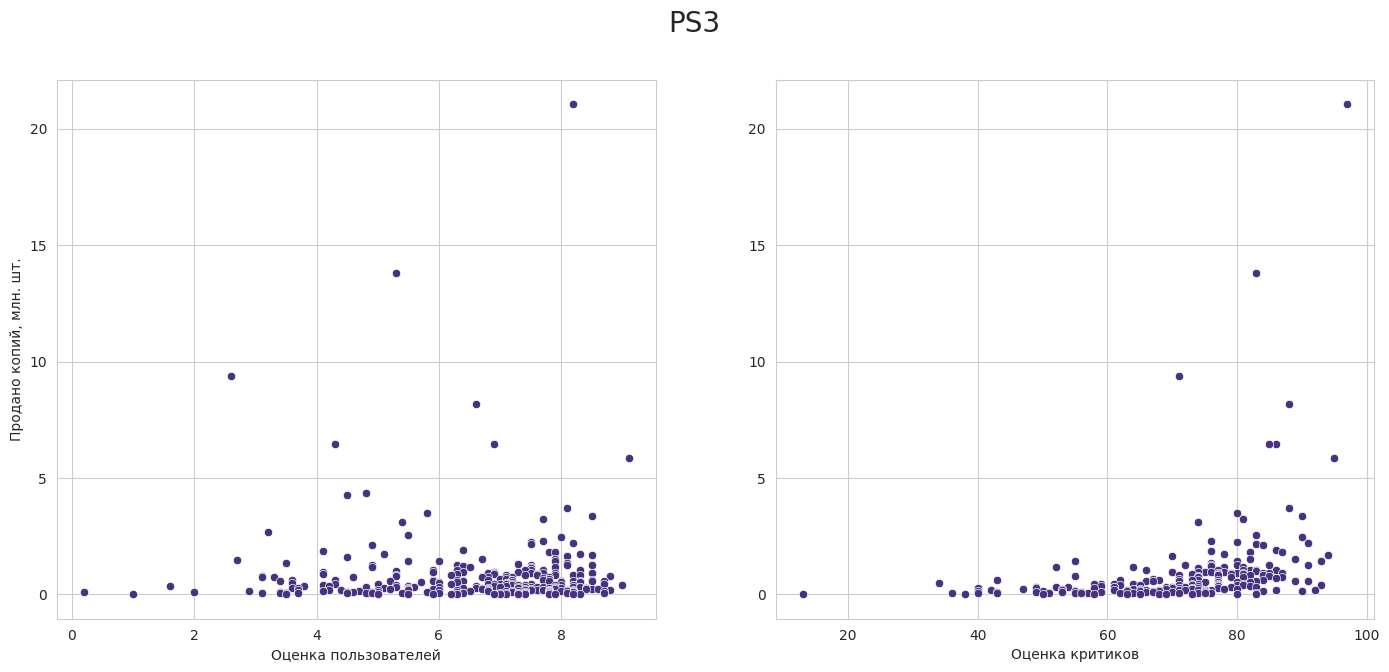

Коэффициент линейной корреляции между продажами игр на платформе PS3 и оценкой пользователей: -0.00514.

Коэффициент линейной корреляции между продажами игр на платформе PS3 и оценкой критиков: 0.331.


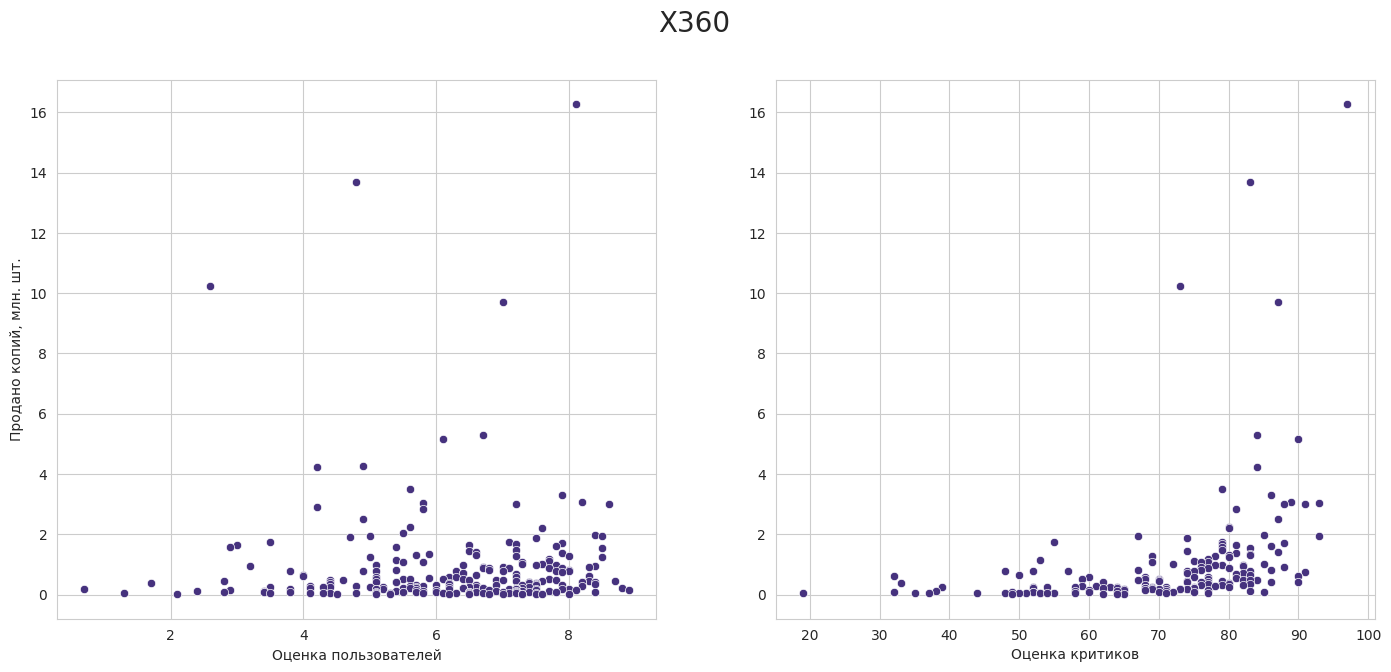

Коэффициент линейной корреляции между продажами игр на платформе X360 и оценкой пользователей: 0.00616.

Коэффициент линейной корреляции между продажами игр на платформе X360 и оценкой критиков: 0.361.


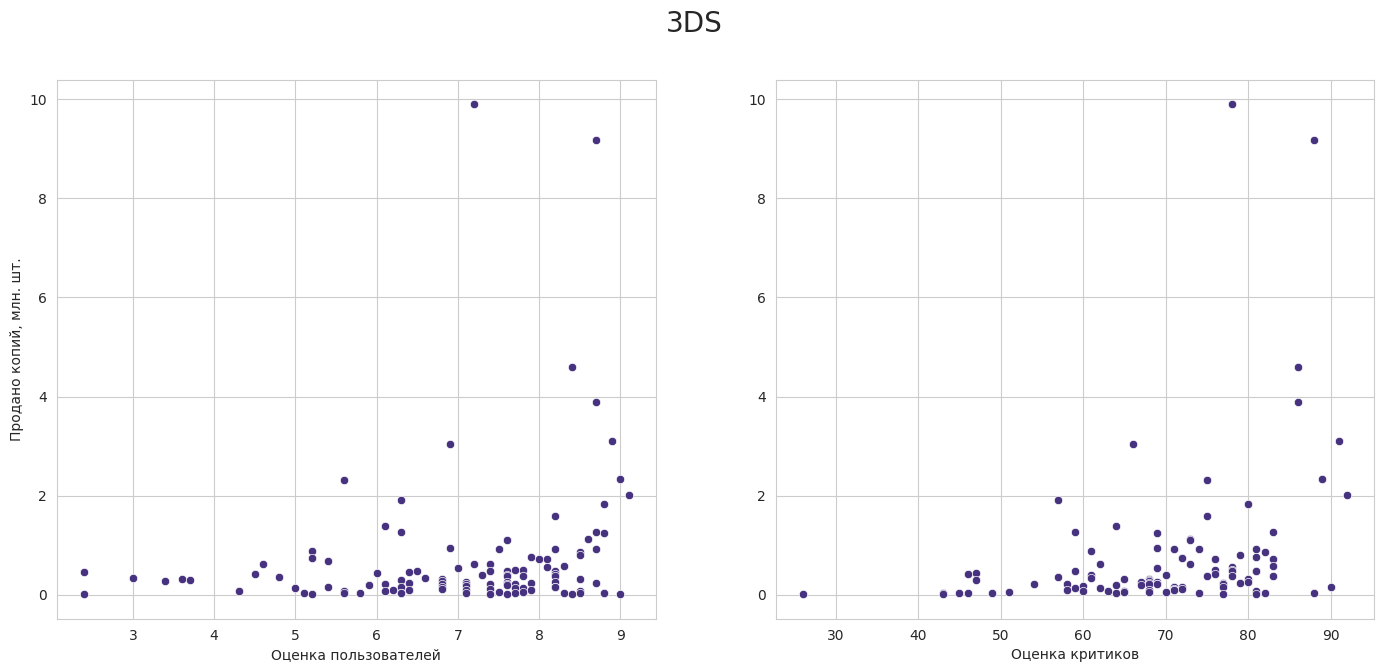

Коэффициент линейной корреляции между продажами игр на платформе 3DS и оценкой пользователей: 0.198.

Коэффициент линейной корреляции между продажами игр на платформе 3DS и оценкой критиков: 0.321.


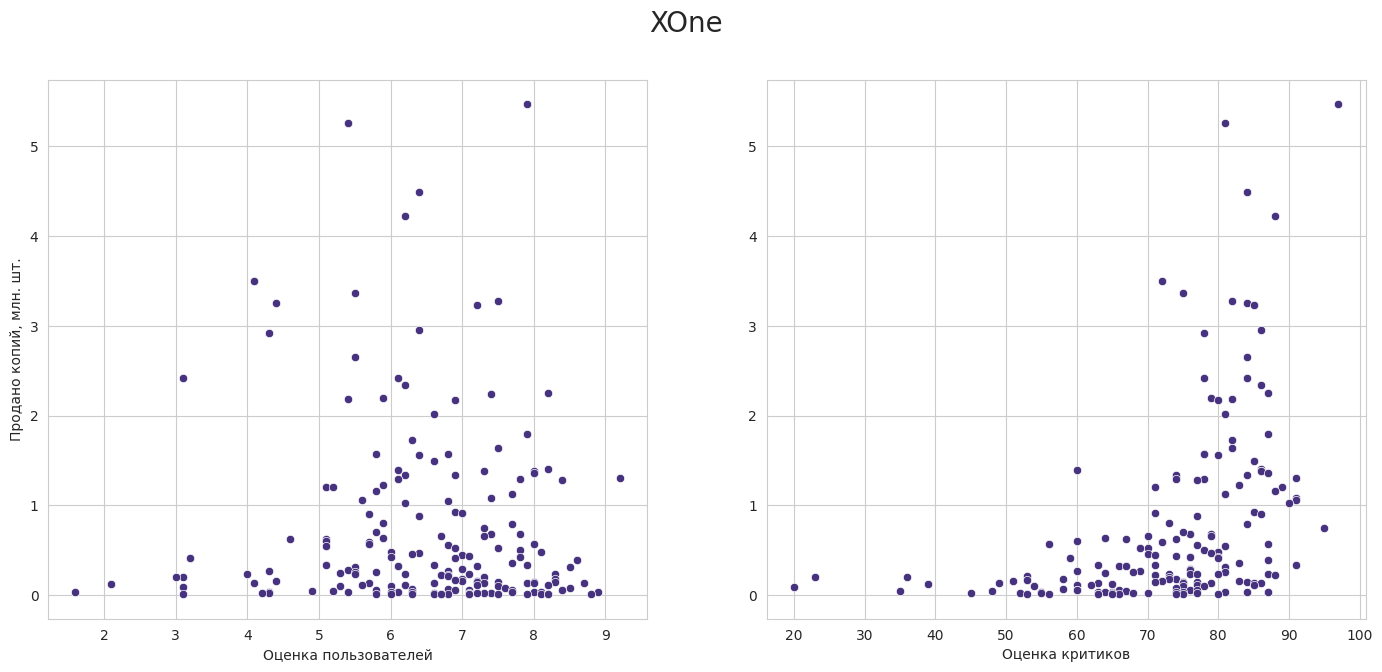

Коэффициент линейной корреляции между продажами игр на платформе XOne и оценкой пользователей: -0.0689.

Коэффициент линейной корреляции между продажами игр на платформе XOne и оценкой критиков: 0.417.


In [47]:
def score_corr(name_platform):
    platform = actual_df[actual_df['platform']==name_platform]
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))
    sns.set_palette('viridis')
    sns.scatterplot(x='user_score', y='total_sales', data=platform.query('user_score >= 0'), ax=axes[0])
    sns.scatterplot(x='critic_score', y='total_sales', data=platform.query('critic_score >= 0'), ax=axes[1])
    fig.suptitle(name_platform, fontsize=20)
    axes[0].set(xlabel='Оценка пользователей')
    axes[1].set(xlabel='Оценка критиков')
    axes[0].set(ylabel='Продано копий, млн. шт.')
    axes[1].set(ylabel='')
    plt.show()

    user_corr = platform.query('user_score >= 0')['user_score'].corr(platform['total_sales'])
    critic_corr = platform.query('critic_score >= 0')['critic_score'].corr(platform['total_sales'])
    print(f"Коэффициент линейной корреляции между продажами игр на платформе {name_platform} и оценкой пользователей: \
{user_corr:.3}.")
    print()
    print(f"Коэффициент линейной корреляции между продажами игр на платформе {name_platform} и оценкой критиков: \
{critic_corr:.3}.")

list_platforms = ['PS4', 'PS3', 'X360', '3DS', 'XOne']
for platform in list_platforms:
    score_corr(platform)

Связь между оценками очень слабая, следовательно, оценки практически никак не влияют на продажи.

Стоит отметить, что из диаграмм рассеивания видно, что наибольшая плотность продаж располагается в диапазонах рейтингов у пользователей - от 6 до 8, а у критиков от 60 до 80.

Здесь все тоже самое:

Связь между оценками очень слабая, следовательно, оценки практически особо никак не влияют на продажи.

Разве что на диаграммах рассеивания наибольшая плотность продаж располагается в диапазонах рейтингов у пользователей - от 6 до 9, а у критиков от 65 до 90, но по факту вывод один и тот же.

### Распределение игр по жанрам

In [48]:
pivot_genre = actual_df.pivot_table(index='genre', values='total_sales', aggfunc = ['count','median','sum'])
pivot_genre.columns = ['count', 'median','sum']
pivot_genre = pivot_genre.sort_values(by = 'sum', ascending = False)
pivot_genre

,count,median,sum
genre,,,
Action,1031,0.12,441.12
Shooter,235,0.44,304.73
Role-Playing,370,0.14,192.80
Sports,268,0.24,181.07
Misc,192,0.12,85.04
Platform,85,0.21,61.00
Racing,115,0.14,53.50
Fighting,109,0.13,44.49
Simulation,80,0.12,35.12


Для наглядности построим круговую диаграмму.

In [49]:
fig = px.pie(actual_df, values=actual_df['total_sales'], names=actual_df['genre'], title='Распределение игр по жанрам с 2012 по 2016 года')
fig.update_layout(
    title_x = 0.5)
fig.show()

Можно заметить, что не всегда количество игр жанра гарантирует хорошие продажи. Например, в жанре **Adventure** выпущено игр значительно больше, чем в некоторых других, но они имеют очень маленькое медианное значение продаж.

Существуют и противоложные случаи, когда медианное значение продаж приближается к максимальному, среди всех жанров, но количество игр очень маленькое: жанр **Shooter**.

Самые прибыльные жанры сочетают два параметра: большое количество игр и высокое медианное значение, но бывают и исключения, жанр **Action** является прям доказательством.

### Вывод

- Рост выпущенных игр начинается с 2001 года (около 500), а пик приходится на 2008-2009 годы (свыше 1400), однако, с наступлением 2010 года начинается спад вплоть до 2016 года, который имеет почти такое же количество как в 2001 году.
- Лучше всего продаются игры на PS2 - более 1,2 млрд. копий, на втором месте Xbox 360.
- При анализе актуальных продаж мы выяснили, что PSP, DS полностью ушли с рынка, а PS3, Xbox 360 и Wii его медленно покидают, пока PS4 набирает обороты.
- В долгосрочном периоде PlayStation 4 показывает себя лучше всего, если говорить о краткосрочном периоде, то PlayStation 3 и Xbox 360.
- Корреляцмя показала, что оценки практически особо никак не влияют на продажи, т.к. коэффициент имеет очень слабую связь.
- Хорошие оценки обеспечивают наибольшая плотность продаж.

## Портрет пользователя для каждого региона

Для портрета пользователя у нас будет следующая структура:
* 5 лидирующих показателя в регионе;

* 📈 уникальная величина (их может быть несколько), которая является важной для нажего итогового анализ и имеют перспективы для увеличения продаж;

* 🔻 2 наименьших показателя, которые имеют долю около 1-2%, более мелкие доли мы не рассчитываем.

### Самые популярные платформы (топ-5)

Для визуализации используем круговую диграмму.

In [50]:
na_sales = actual_df.groupby('platform',as_index=False)['na_sales'].sum()
eu_sales = actual_df.groupby('platform',as_index=False)['eu_sales'].sum()
jp_sales = actual_df.groupby('platform',as_index=False)['jp_sales'].sum()

In [51]:
fig = go.Figure(data=[go.Pie(labels=na_sales['platform'], values=na_sales['na_sales'], title='Популярные платформы в NA')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

fig = go.Figure(data=[go.Pie(labels=eu_sales['platform'], values=eu_sales['eu_sales'], title='Популярные платформы в EU')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

fig = go.Figure(data=[go.Pie(labels=jp_sales['platform'], values=jp_sales['jp_sales'], title='Популярные платформы в JP')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

**Северная Америка:**
1. **Xbox 360** (23,7%);
2. **PS4** (18,4%);
3. **PS3** (17,5%);
4. **Xbox One** (15,8%);
5. Nintendo **3DS** (9,36%);

📈 **PC** находится на **7 месте** (3,24%);

🔻 Наименьшая доля у PS Vita и Wii (чуть в районе 2% у каждой).

**Европа:**

1. **PS4** (27,8%);
2. **PS3** (18,4%);
3. **Xbox 360** (14,7%);
4. **Xbox One** (10,2%);
5. Nintendo **3DS** (8,41%);

📈 **PC** находится на **6 месте** (7,45%);

🔻 Наименьшая доля у PS Vita и Wii (чуть более 2% у каждой).

**Япония:**
1. Nintendo **3DS** (45,6%);
2. **PS3** (18,3%);
3. **PSV** (14,7%);
4. **PS4** (8,29%);

📈 **PC** находится на **6 месте** (7,45%);

🔻 Наименьшая доля у DS и Wii (чуть более 3% у каждой);
* Xbox 360 имеет долю 0,85%.

#### Вывод

- В каждом регионе лидирует разная платформа;
- В Японии и Европе на втором месте PS3, а в Северной Америке - PS4;
- В Северной Америке и Европе Xbox One на четвертом месте, а в Японии - PS4;
- PC ни в одном регионе входит в первую пятерку;
- В каждом регионе на Wii приходится наименьшая доля;
- В Японии Xbox 360 совсем не популярен (0,85%).

### Самые популярные жанры (топ-5)

Для визуализации используем круговую диграмму.

In [52]:
na_genres = actual_df.groupby('genre',as_index=False)['na_sales'].sum()
eu_genres = actual_df.groupby('genre',as_index=False)['eu_sales'].sum()
jp_genres = actual_df.groupby('genre',as_index=False)['jp_sales'].sum()

In [53]:
fig = go.Figure(data=[go.Pie(labels=na_genres['genre'], values=na_genres['na_sales'], title='Популярные жанры в NA')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

fig = go.Figure(data=[go.Pie(labels=eu_genres['genre'], values=eu_genres['eu_sales'], title='Популярные жанры в EU')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

fig = go.Figure(data=[go.Pie(labels=jp_genres['genre'], values=jp_sales['jp_sales'], title='Популярные жанры в JP')]);
fig.update_layout(
    title_x = 0.5)
fig.show()

**Северная Америка:**
1. **Action** (30,1%);
2. **Shooter** (24,5%);
3. **Sports** (13,8%);
4. **Role-Playing** (10,8%);
5. **Misc** (6,46%);

📈 **Racing** находится на **8 месте** (2,91%);

🔻 Наименьшая доля у Straregy и Adventure (менее 2% у каждой).

**Европа:**
1. **Action** (31,4%);
2. **Shooter** (22,4%);
3. **Sports** (13,6%);
4. **Role-Playing** (9,58%);
5. **Racing** (5,38%);

📈 **Racing** находится на **5 месте** (5,38%);

🔻 Наименьшая доля у Straregy и Adventure (обе в районе 1-2%).

**Япония:**
1. **Action** (45,6%);
2. **Misc** (18,3%);
3. **Racing** (10,9%);
4. **Platform** (8,29%);
5. **Shooter** (6,76%);

📈 **Racing** находится на **3 месте** (10,9%);

🔻 Наименьшая доля у Role-Playing и Adventure (почти 2% у каждой).

#### Вывод

- В каждом регионе лидирует Action;
- В Северной Америке и Европе на втором месте Shooter, а в Японии - Misc;
- Racing в Японии и Европе входит в первую пятерку, а в Северной Америке лишь на 8 месте;
- В каждом регионе на Adventure приходится наименьшая доля;
- В Японии Shooter совсем не популярен (6,76%).

### Влияние рейтинга ESRB на продажи

Для визуализации используем круговую диграмму.

In [54]:
na_rating = actual_df.groupby('rating',as_index=False)['na_sales'].sum()
eu_rating = actual_df.groupby('rating',as_index=False)['eu_sales'].sum()
jp_rating = actual_df.groupby('rating',as_index=False)['jp_sales'].sum()

In [55]:
jp_rating

,rating,jp_sales
0,E,28.33
1,E10+,8.19
2,M,21.20
3,T,26.02
4,unknown,108.84


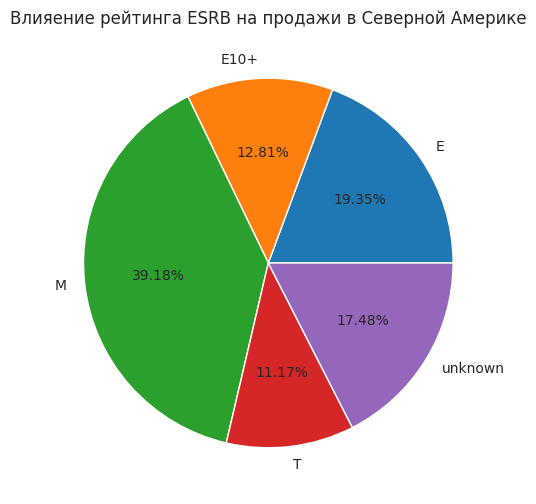

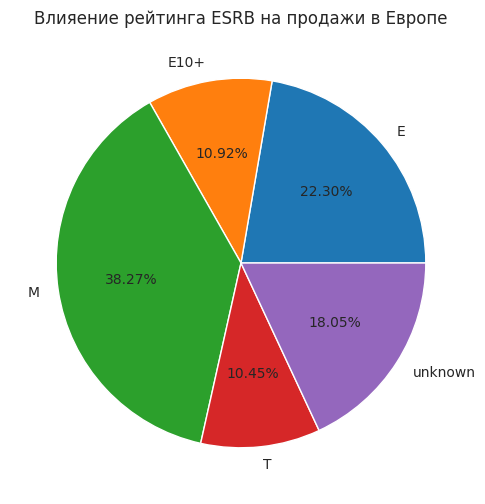

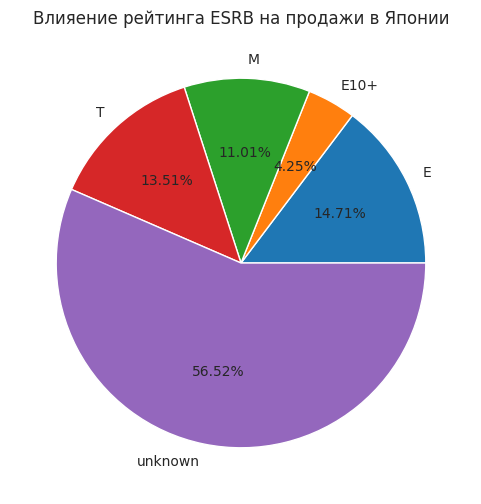

In [56]:
na_rating.plot(kind='pie',y="na_sales", autopct='%1.2f%%', legend=False, labels=na_rating['rating'],
               title = "Влияение рейтинга ESRB на продажи в Северной Америке", figsize=(6,6),ylabel='',
               colors=sns.color_palette("tab10"))
eu_rating.plot(kind='pie',y="eu_sales", autopct='%1.2f%%', legend=False, labels=eu_rating['rating'],
               title = "Влияение рейтинга ESRB на продажи в Европе", figsize=(6,6),ylabel='',
               colors=sns.color_palette("tab10"))
jp_rating.plot(kind='pie',y="jp_sales", autopct='%1.2f%%', legend=False, labels=jp_rating['rating'],
               title = "Влияение рейтинга ESRB на продажи в Японии", figsize=(6,6),ylabel='',
               colors=sns.color_palette("tab10"));

- Доля рейтингов у Европы и Северной Америки примерно на одном уровне в долевом соотношении. На первом месте рейтинг «M» («Mature») — «Для взрослых», что соответствует популярным жанрам Action и Shooter.
- В Японии «M» также на первом месте, правда многие игры вообще не имеют рейтинга, поскольку там ESRB не является обязательным.

### Вывод

Резюмируя анализ можно выделить следующие ключевые моменты:
- В каждом регионе лидирует своя платформа;
- В Японии и Европе на втором месте PS3, а в Северной Америке - PS4, что свидетельствует о популярности консолей Sony, которая обсуловлена экслюзивами в виде игр;
- В каждом регионе по жанрам лидирует Acttion;
- В каждом регионе лидирует первом месте рейтинг «M» («Mature») — «Для взрослых», что соответствует популярным жанрам Action и Shooter.
- В Японии многие игры вообще не имеют рейтинга, поскольку там ESRB не является обязательным и имеет больший вес в Северной Америке.

## Проверка гипотез

У нас имеется 2 гипотезы:

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

В рамках данного проекта в качестве `alpha` (порогового уровеня статистической значимости) будет принято значение в размере 5% (0.05).

В качестве метода для проверки двусторонниъ гипотез будет использован t-тест.

### Рейтинги Xbox One и PC

Проверка гипотезы:

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: Средний пользовательский рейтинг Xbox One = Средний пользовательский рейтинг PC`
H_1: Средний пользовательский рейтинг Xbox One ≠ Средний пользовательский рейтинг PC`
alpha = 0.05
```

Создадим переменные для наших выборок с пользовательскими рейтингами платформ Xbox One и PC.

In [57]:
user_score_xone = actual_df.query('user_score >= 0').loc[actual_df.loc[:,'platform'] == 'XOne']['user_score']
user_score_pc = actual_df.query('user_score >= 0').loc[actual_df.loc[:,'platform'] == 'PC']['user_score']

In [58]:
print('Дисперсия совокупности рейтинга пользователей платформы Xbox One:',np.var(user_score_xone))
print('Дисперсия совокупности рейтинга пользователей платформы PC:',np.var(user_score_pc))

Дисперсия совокупности рейтинга пользователей платформы Xbox One: 1.8965188383045526
Дисперсия совокупности рейтинга пользователей платформы PC: 2.7569952398906588


Дисперсии совершенно разные, поэтому нужно провести проверку.

In [59]:
results = stats.ttest_ind(
    user_score_xone,
    user_score_pc,
    equal_var=False)

alpha = 0.05 # значение уровня значимости

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Значит средние пользовательские рейтинги платформ Xbox One и PC с вероятностью 38.7% одинаковые.

### Рейтинги Action и Sports

Проверка гипотезы:

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;


```
H_0: Средний пользовательский рейтинг Xbox One = Средний пользовательский рейтинг PC`
H_1: Средний пользовательский рейтинг Xbox One ≠ Средний пользовательский рейтинг PC`
alpha = 0.05
```

Создадим переменные для наших выборок с пользовательскими рейтингами жанров Action и Sports.

In [60]:
user_score_action = actual_df.query('user_score > 0').loc[actual_df.loc[:,'genre'] == 'Action']['user_score']
user_score_sports = actual_df.query('user_score > 0').loc[actual_df.loc[:,'genre'] == 'Sports']['user_score']

In [61]:
print('Дисперсия совокупности рейтинга пользователей платформы Action:',np.var(user_score_xone))
print('Дисперсия совокупности рейтинга пользователей платформы Sports:',np.var(user_score_pc))

Дисперсия совокупности рейтинга пользователей платформы Action: 1.8965188383045526
Дисперсия совокупности рейтинга пользователей платформы Sports: 2.7569952398906588


Дисперсии совершенно разные, поэтому нужно провести проверку.

In [62]:
results = stats.ttest_ind(
    user_score_action,
    user_score_sports,
    equal_var=False)

alpha = 0.05 # значение уровня значимости

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.24307776572644e-20
Отвергаем нулевую гипотезу


Значение наблюдаемого результата составляет 4.24, которое означает, что средние пользовательские рейтинги жанров Action и Sports совершенно не могут быть одинаковыми - они очень разные.

### Вывод

**Подтвердили гипотезу:** средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Опровергли гипотезу:** средние пользовательские рейтинги жанров Action и Sports совершенно разные.

## Общий вывод

В данном исследовании мы данные по клиентам фитнес-центра за месячный период..

Перед тем как приступить к исследованию мы провели:

1. Предварительную обработку полученных данных - привели названия столбцов к нижнему регистру и типы данных, где это необходимо, провели проверку на пропущенные значения, дубликаты.
2. Была проведена проверка на аномальные значения и выбросы в данных.
3. Провели исследовательский анализ данных и подробно изучили популярные жанры и платформы в игровом сегменте.
5. Составили портреты пользователей по регионам.
6. Провели проверку двух гипотез с помощью t-теста.


Исходя из проведенного анализа сделать следующие выводы:

- Рост выпущенных игр начинается с 2001 года (около 500), а пик приходится на 2008-2009 годы (свыше 1400), однако, с наступлением 2010 года начинается спад вплоть до 2016 года, который имеет почти такое же количество как в 2001 году.
- Примерно каждые 5 лет появляется новая платформа. В целом платформа актуальна лет 5, а потом примерно в течение года после этого срока она перестает существовать. Однако, средний срок жизни платформы составляет 6 лет.
- При анализе актуальных продаж мы выяснили, что PSP, DS полностью ушли с рынка, а PS3, Xbox 360 и Wii его медленно покидают, пока PS4 и Xbox One набирают обороты, но последняя делает это более медленно.
- В долгосрочном периоде PlayStation 4 и Xbox One показывают себя лучше всего, если говорить о краткосрочном периоде, то PlayStation 3 и Xbox 360.
- Корреляция показала, что оценки практически особо никак не влияют на продажи, т.к. коэффициент имеет очень слабую связь.
- Хорошие оценки обеспечивают наибольшая плотность продаж.
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Средние пользовательские рейтинги жанров Action и Sports совершенно разные.
- Возможно стоит присмотреться к PC, низкие цифры продаж связаны с развитым пиратством, из-за которого мало кто покупает лицинзионные игры.

## Рекомендации

Отделу маркетинга рекомендуется потратить рекламный бюджет на глобльное по уровню промо к играм жанра Action, которые есть на PS3, но если рассматривать Запад, то также сюда можно включить Xbox 360 и жанр Shooter, на оценки пользователей и критиков можно не акцентировать внимание при выборе игр, но более высокие оценки обеспечивают более стабильные продажи. Что до возрастного рейтинга, то в каждом регионе он разный, также он может зависеть от страны.